## Creating Constrained, Contiguous Regions with SKATER

The SKATER clustering algorithm I'm using can be installed from GitHub:

* `$ pip install git+https://github.com/pysal/region.git#egg=region`

We're not aware of a solid SKATER implementation in Python, so we will use a version that's being developed within PySAL.

### Retrieve the data

In [1]:
%matplotlib inline
import geopandas as gpd
from region.skater.skater import Spanning_Forest
from libpysal import weights
import datasets

In [2]:
nyctracts = datasets.get_nyc_census_tracts()
nyctracts.sample(2)

,cartodb_id,geoid,median_income_2011_2015,total_pop_2011_2015,longitude,latitude,geometry
49,2074,36005007800,30437,6518,-73.852393,40.829482,"MULTIPOLYGON (((-73.85598 40.83183, -73.85474 ..."
958,3073,36047084600,48182,1704,-73.927385,40.641985,"MULTIPOLYGON (((-73.92960 40.64443, -73.92572 ..."


### Visualize polygons on map

In [3]:
from cartoframes.viz import Map, Layer, color_continuous_style, color_continuous_legend, histogram_widget

Layer(nyctracts,
        style = color_continuous_style("median_income_2011_2015",
                            stroke_color="transparent"),
        legends=color_continuous_legend(title="Median Income (2011-2015)"),
        widgets=[histogram_widget('median_income_2011_2015')]
    )

In [4]:
nyctracts.head()

,cartodb_id,geoid,median_income_2011_2015,total_pop_2011_2015,longitude,latitude,geometry
0,2025,36005000200,72034,5403,-73.858755,40.810277,"MULTIPOLYGON (((-73.86148 40.81503, -73.85972 ..."
1,2026,36005000400,74836,5915,-73.852648,40.810195,"MULTIPOLYGON (((-73.85552 40.81583, -73.85575 ..."
2,2027,36005001600,32312,5879,-73.858222,40.818384,"MULTIPOLYGON (((-73.86246 40.81925, -73.86153 ..."
3,2028,36005001900,37936,2591,-73.916212,40.803210,"MULTIPOLYGON (((-73.90021 40.79926, -73.90028 ..."
4,2029,36005002000,18086,8516,-73.866029,40.817895,"MULTIPOLYGON (((-73.87050 40.82036, -73.86575 ..."


### Clustering using SKATER

In [5]:
import warnings
from libpysal.weights import w_union, W, Rook
import utils

# manually-created connections on bridges using db-id
bridge_connections = utils.get_nyc_bridge_connections()

# map DB id to row id for use in agglomerative clustering below
index_rownum_mapping = {idx: ridx for ridx, idx in enumerate(nyctracts.cartodb_id)}
mapped_connections = dict()

for k in bridge_connections:
    mapped_connections[index_rownum_mapping[k]] = [
        index_rownum_mapping[v] for v in bridge_connections[k]
    ]

# ignore disconnected component warnings as they're expected
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    wgt = Rook.from_dataframe(nyctracts)
    mapped_weights = W(mapped_connections)

# all components are expected to be connected (no warnings)
wgt_unioned = w_union(wgt, mapped_weights)

In [6]:
import numpy as np
from sklearn.preprocessing import StandardScaler

col = "median_income_2011_2015"

ss = StandardScaler()
pop_scaled = ss.fit_transform(nyctracts[[col]].values) + 0.01 * np.random.random(
    (wgt_unioned.n, 1)
)

/Users/giulia/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/giulia/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [7]:
np.random.seed(1239)

n_clusters = 16

sf = Spanning_Forest()

result = sf.fit(n_clusters, wgt_unioned, pop_scaled, quorum=5, verbose=True)

finding cut...: 100%|██████████| 2142/2142 [00:03<00:00, 602.27it/s]


In [8]:
nyctracts["labels"] = [str(l).zfill(2) for l in result.current_labels_]

In [9]:
from cartoframes.viz import color_category_style, category_widget
Layer(nyctracts,
        style = color_category_style("labels",
                            top=16),
        widgets=[category_widget('labels')]
    )

Text(0.5, 1.0, 'Cluster Mean Values versus Number of Units')

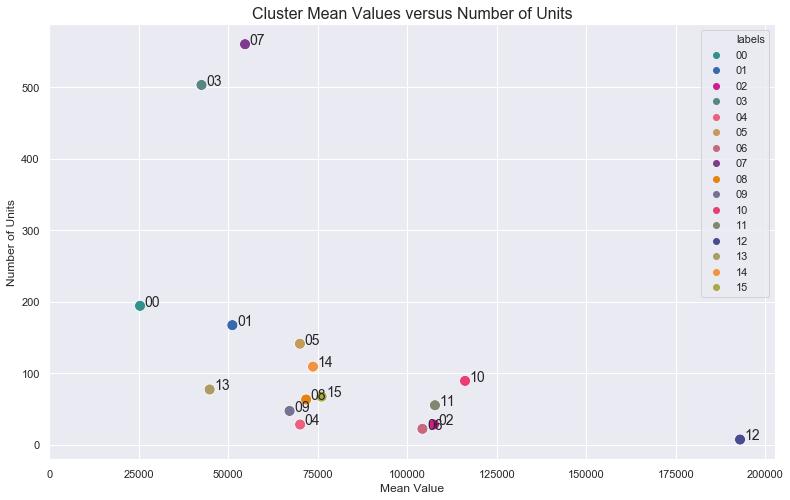

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

agged = (
    nyctracts.groupby("labels")["median_income_2011_2015"]
    .agg(["count", "mean"])
    .reset_index()
    .sort_values("count", ascending=False)
)

# retrieve hex values from legend
palette = [
    "#7f3c8d",
    "#588681",
    "#32918b",
    "#3969ac",
    "#c59b5a",
    "#f19442",
    "#e73f74",
    "#ad9b64",
    "#aaaa45",
    "#e68310",
    "#828771",
    "#757393",
    "#cf1c90",
    "#ec617d",
    "#c56a7d",
    "#4b4b8f",
]
palette_mapping = dict(zip(agged.labels, palette))

fig, ax = plt.subplots(1, 1, figsize=(13, 8))

ax = sns.scatterplot(
    data=agged, x="mean", y="count", hue="labels", palette=palette_mapping, s=120
)
ax.set(
    xlabel="Mean Value", ylabel="Number of Units", xlim=[0, agged["mean"].max() * 1.05]
)

for x, y, l in zip(agged["mean"], agged["count"], agged.index):
    ax.annotate(str(l).zfill(2), (x + 1300, y), fontsize=14)

ax.set_title("Cluster Mean Values versus Number of Units", fontsize=16)

- The cluster comprising most of the southern Bronx, east Harlem, and a small part of the Upper West Side that has a high number of public housing projects: this large area has a very low median income
- The cluster of seven Upper East Side census tracts is seen on the lower right of the graph. It has a very high median income on average and is small compared to some of the other clusters.
- Large swaths of Brooklyn, Queens, and Staten Island are individually homogenous with respect to median income
- Brooklyn Heights and Dumbo stand out as areas with high median income compared to the rest of Brooklyn. This cluster would potentially be combined with the parts of Manhattan across the Brooklyn or Manhattan bridges if we added those connections.
- The clusters between 100k and 125k median income and smaller than 100 units are all close: Manhattan's lower east and west sides and Brooklyn Heights, Dumbo, and Park Slope